## Social Media Sanctions and Misinformation Sharing
We are going to see through various steps if politic orientation has to do with social media sanctions

## Important Libraries
Please install in your local machine the below libraries.

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from IPython.display import display
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA

## Twitter Suspensions after the 2020 Election
Below, you will see a crosstab that shows the relationship between the variables politics_hashtag ( either 0 for Biden or 1 for Trump) and suspended (which indicates whether a user was suspended, 1 for yes, 0 for no). After that, we calculate the suspention rate per each hashtag, which is calculated by the total suspensions divided by the total members of the group. After that, we calculate the relative likelihood of suspension, by deviding the two suspension rates. We can see that the result is 4.4 which means that a Trump hashtag is 4.4% more likely to be suspended.

In [26]:
data = pd.read_csv('mosleh_et_al_data.csv')

# Crosstabulation for politics_hashtag (0 for Biden, 1 for Trump) and suspended
crosstab = pd.crosstab(data['politics_hashtag'], data['suspended'], margins=True)

suspension_rate_trump = crosstab.loc[1, 1] / crosstab.loc[1, 'All']  # For #Trump2020
suspension_rate_biden = crosstab.loc[0, 1] / crosstab.loc[0, 'All']  # For #VoteBidenHarris2020

# Calculate relative likelihood
relative_likelihood = suspension_rate_trump / suspension_rate_biden

# Print results
print("Crosstabulation:")
display(crosstab)
print(f"\nSuspension rate for #Trump2020: {suspension_rate_trump:.4f}")
print(f"Suspension rate for #VoteBidenHarris2020: {suspension_rate_biden:.4f}")
print(f"Relative likelihood of suspension (Trump vs. Biden): {relative_likelihood:.1f}%")

Crosstabulation:


suspended,0,1,All
politics_hashtag,,,
0,4295,200,4495
1,3623,882,4505
All,7918,1082,9000



Suspension rate for #Trump2020: 0.1958
Suspension rate for #VoteBidenHarris2020: 0.0445
Relative likelihood of suspension (Trump vs. Biden): 4.4%


After that, we performed a Chi-square test. The Chi-Square statistic represents the difference between the observed and expected values. The result indicates a quite big significance between the politic hashtag and the suspension. Additionaly, the p-value is close to 0, smaller than 0.05 which rejects that the null hypothesis that there is no relationship between the variables.

In [27]:
contingency_table = crosstab.iloc[0:2, 0:2].values

# Perform the chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("\nChi-Square Test Results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Degrees of freedom: {dof}")


Chi-Square Test Results:
Chi-square statistic: 485.4671
P-value: 1.3808e-107
Degrees of freedom: 1


## Distributions of Relative Frequency of Low Quality
Firstly, we create a Kernel Density Estimation (KDE) plot to visualize the distribution of low-quality news sharing (z-score standardized) for two groups based on political hashtags. We use the 'lowqual_pr2019_fc' column which represents the scores of 8 fact checkers.

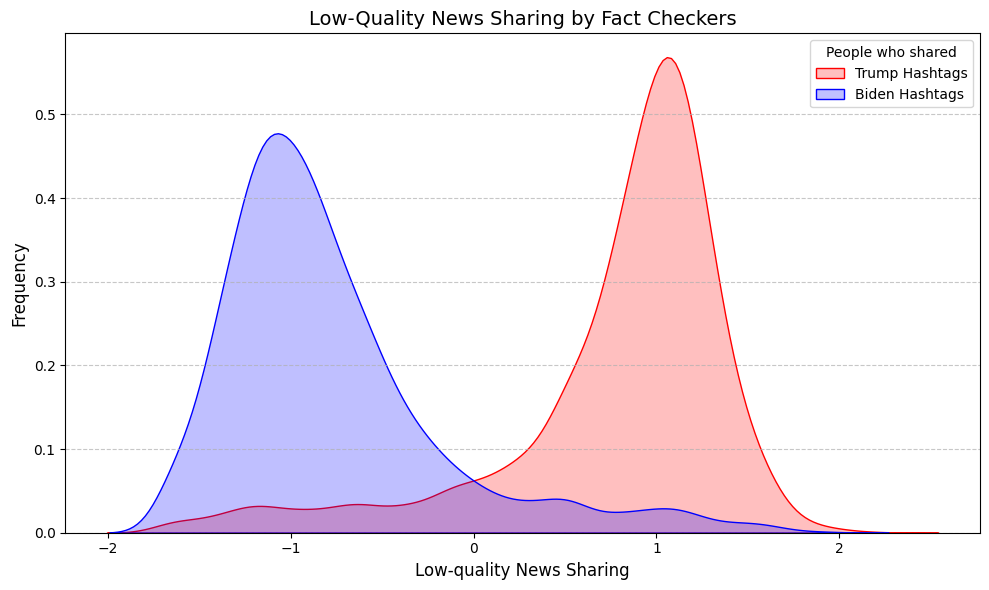

In [28]:
data['lowqual_zscore'] = (data['lowqual_pr2019_fc'] - data['lowqual_pr2019_fc'].mean()) / data['lowqual_pr2019_fc'].std()

# Create a long-form DataFrame with 'lowqual_zscore' and 'politics_hashtag'
long_data = data[['lowqual_zscore', 'politics_hashtag']]

# Create the plot of crowd
plt.figure(figsize=(10, 6))

#custom plot colors
custom_palette = ['blue', 'red'] 

# Plot the KDE for both groups in a single plot
sns.kdeplot(data=long_data, x='lowqual_zscore', hue='politics_hashtag', fill=True,  palette=custom_palette)

# Customize plot
plt.title('Low-Quality News Sharing by Fact Checkers', fontsize=14)
plt.xlabel('Low-quality News Sharing', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='People who shared', labels=['Trump Hashtags', 'Biden Hashtags'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Display the plot
plt.show()

Secondly, we create another Kernel Density Estimation (KDE) plot to visualize the distribution of low-quality news sharing (z-score standardized) for 
two groups based on political hashtags. We use the 'lowqual_pr2019_crowd' column which represents the scores of the crowd.

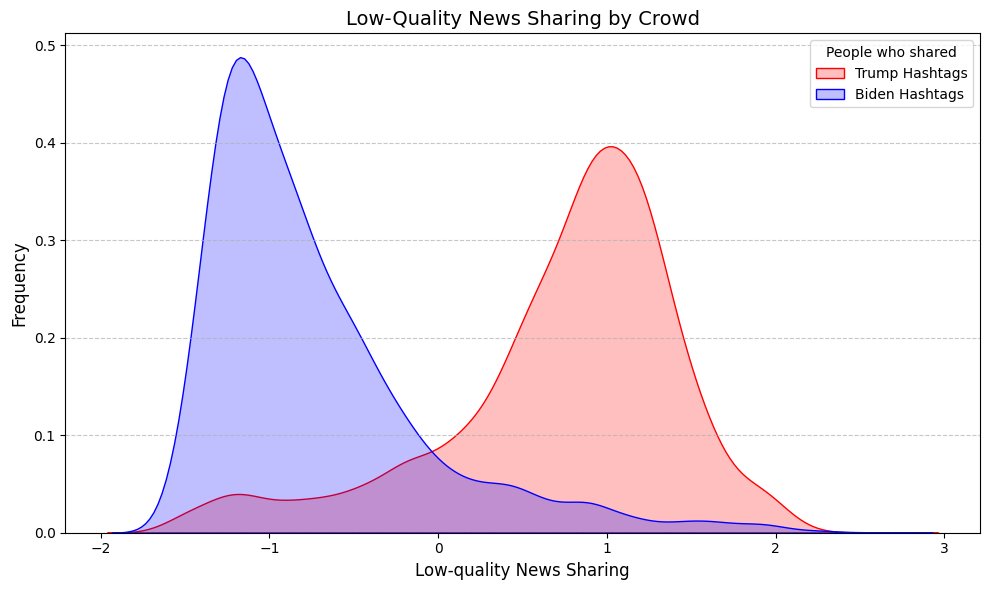

In [29]:
data['lowqual_zscore'] = (data['lowqual_pr2019_crowd'] - data['lowqual_pr2019_crowd'].mean()) / data['lowqual_pr2019_crowd'].std()

# Create a long-form DataFrame with 'lowqual_zscore' and 'politics_hashtag'
long_data = data[['lowqual_zscore', 'politics_hashtag']]

# Create the plot of crowd
plt.figure(figsize=(10, 6))

#custom plot colors
custom_palette = ['blue', 'red'] 

# Plot the KDE for both groups in a single plot
sns.kdeplot(data=long_data, x='lowqual_zscore', hue='politics_hashtag', fill=True, palette=custom_palette)

# Customize plot
plt.title('Low-Quality News Sharing by Crowd', fontsize=14)
plt.xlabel('Low-quality News Sharing', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='People who shared', labels=['Trump Hashtags', 'Biden Hashtags'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Display the plot
plt.show()

## Low-quality News Sharing on Twitter
This code performs t-tests and calculates effect sizes for low quality news variables across two groups defined by the 'politics_hashtag' column.
We measure the effect size by the Cohen's d and Hedges' g.

In [30]:
# Function to calculate pooled standard deviation
def pooled_std(s1, s2, n1, n2):
    return np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

# Function to calculate Cohen's d
def cohen_d(x1, x2):
    mean1 = np.mean(x1)
    mean2 = np.mean(x2)
    std1 = np.std(x1, ddof=1)
    std2 = np.std(x2, ddof=1)
    n1 = len(x1)
    n2 = len(x2)
    
    # Pooled standard deviation
    pooled = pooled_std(std1, std2, n1, n2)
    
    # Cohen's d
    d = (mean1 - mean2) / pooled
    
    return d

# Function to calculate Hedges' g
def hedges_g(d, n1, n2):
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    g = d * correction
    return g

# Perform t-test and calculate effect size for each variable
def t_test_and_effect_size(data, variable):
    group1 = data[data['politics_hashtag'] == 1][variable]
    group2 = data[data['politics_hashtag'] == 0][variable]

    group1 = data[data['politics_hashtag'] == 1][variable].dropna()
    group2 = data[data['politics_hashtag'] == 0][variable].dropna()
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    # Calculate Cohen's d
    d = cohen_d(group1, group2)
    
    # Calculate Hedges' g
    n1 = len(group1)
    n2 = len(group2)
    g = hedges_g(d, n1, n2)
    
    return t_stat, p_value, d, g

# List of variables to analyze
variables = [
    'lowqual_pr2019_fc', 
    'lowqual_afm', 
    'lowqual_mbfc', 
    'lowqual_lasser2019', 
    'lowqual_pr2019_crowd', 
    'lowqual_pr2019_crowdrep'
]

# Dictionary to store results
results = {}

for variable in variables:
    t_stat, p_value, d, g = t_test_and_effect_size(data, variable)
    results[variable] = {'t-statistic': t_stat, 'p-value': p_value, 'Cohen\'s d': d, 'Hedges\' g': g}

# Display the results
results_df = pd.DataFrame(results).T
display(results_df)

,t-statistic,p-value,Cohen's d,Hedges' g
lowqual_pr2019_fc,119.246476,0.0,2.521188,2.520977
lowqual_afm,102.711200,0.0,2.164878,2.164698
lowqual_mbfc,97.584148,0.0,2.057540,2.057369
lowqual_lasser2019,102.679384,0.0,2.163831,2.163650
lowqual_pr2019_crowd,102.501955,0.0,2.166782,2.166601
lowqual_pr2019_crowdrep,61.083019,0.0,1.291464,1.291356


The above results indicate a strong relationship between the low quolity metrics and the politics hashtags. The t-statistic in all the cases is quite big
and the p-values are near 0, which means that we can reject the null hypothesis that there is no relationship between the variables. Additionally, the effect sizes of d and g are very large, which indicates that the trump hashtag is more likely to share low quality news.

## Sharing Lower-quality News Sources and Conservative Ideology
This code calculates and visualizes the correlations between variables representing low-quality news sharing and political ideology metrics in the dataset. Then it displays the results in a heatmap.

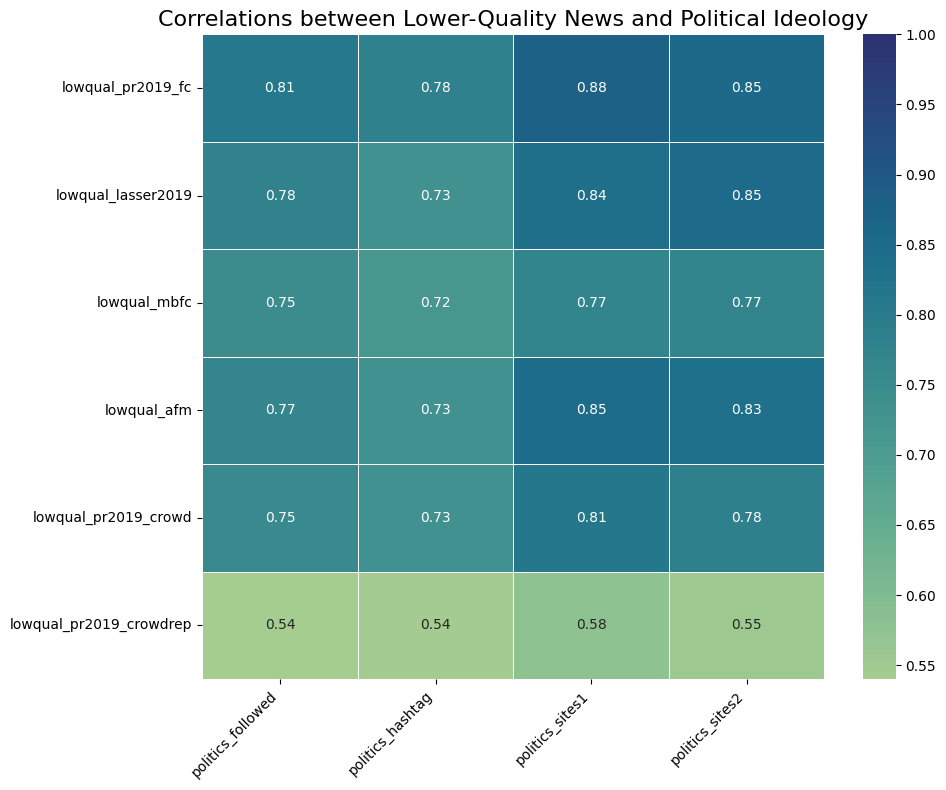

In [32]:
# Select the relevant columns for lower-quality news and political ideology
lowqual_columns = [
    'lowqual_pr2019_fc',
    'lowqual_lasser2019',
    'lowqual_mbfc',
    'lowqual_afm',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]

politics_columns = [
    'politics_followed',
    'politics_hashtag',
    'politics_sites1',
    'politics_sites2'
]

# Subset the data to include only the relevant columns
subset_data = data[lowqual_columns + politics_columns]

# Create an empty correlation matrix for lowqual_columns vs politics_columns
correlation_matrix = pd.DataFrame(index=lowqual_columns, columns=politics_columns)

# Calculate correlations between each lowqual_column and each politics_column
for lowqual_col in lowqual_columns:
    for politics_col in politics_columns:
        correlation_matrix.loc[lowqual_col, politics_col] = subset_data[lowqual_col].corr(subset_data[politics_col])

# Display the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
ax=sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='crest', fmt='.2f', linewidths=0.5, vmin=0.54, vmax=1, 
            cbar_kws={'ticks': [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85 , 0.90, 0.95, 1]})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Correlations between Lower-Quality News and Political Ideology', fontsize=16)
plt.tight_layout()
plt.show()

The correlation results show a strong relationship between the political ideology and the low quality news sharing, similar to the t-test results.

## News Sharing Can Help Explain Suspension, Using Single Predictors
This code evaluates the predictive strength of various features related to political orientation and low-quality news sharing for determining the likelihood of a user being suspended. It uses probit regression and bootstrap sampling to calculate the Area Under the Curve (AUC) and its confidence intervals for each feature. Then it visualizes the results in a bar chart with the auc mean each time and the errobars that show the confidence internvals.

,Predictor,Mean AUC,CI Lower,CI Upper
0,politics_hashtag,0.679220,0.668208,0.691902
1,politics_sites1,0.699928,0.688549,0.714880
2,politics_sites2,0.704469,0.692278,0.717258
3,politics_followed,0.684747,0.672134,0.695931
4,lowqual_afm,0.715301,0.702348,0.730106
5,lowqual_mbfc,0.706015,0.692494,0.723883
6,lowqual_lasser2019,0.705436,0.694714,0.717648
7,lowqual_pr2019_fc,0.698069,0.686025,0.712486
8,lowqual_pr2019_crowd,0.685365,0.673887,0.698148


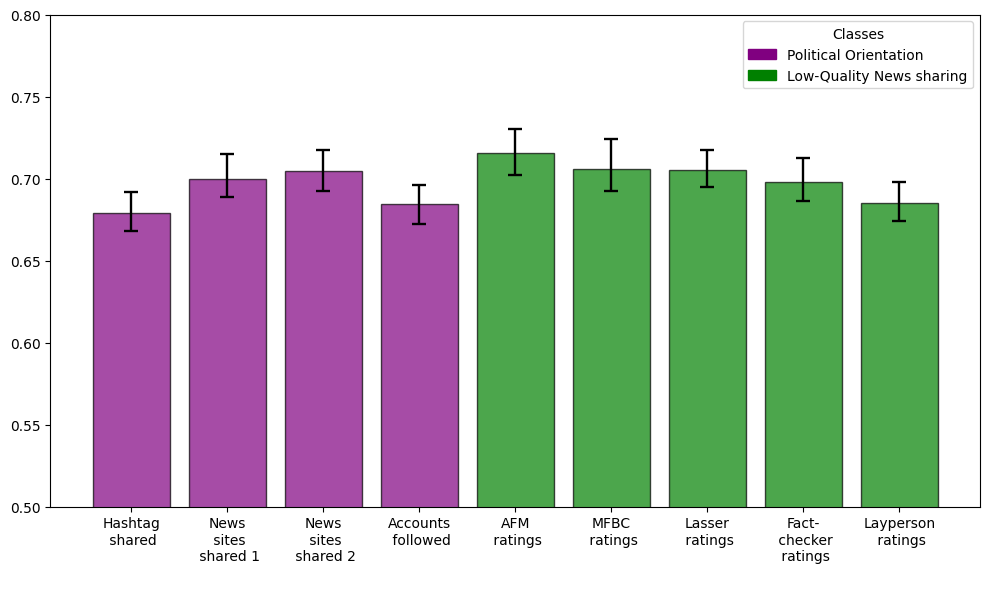

In [33]:
data = pd.read_csv('mosleh_et_al_data.csv')
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

# Define predictors and target variable
political_orientation_predictors = [
    'politics_hashtag',
    'politics_sites1',
    'politics_sites2',
    'politics_followed'
]
low_quality_predictors = [
    'lowqual_afm',
    'lowqual_mbfc',
    'lowqual_lasser2019',
    'lowqual_pr2019_fc',
    'lowqual_pr2019_crowd'
]
target = 'suspended'

# Combine both sets of predictors
predictors = political_orientation_predictors + low_quality_predictors
predictors_name=['Hashtag\n shared', 'News\n sites\n shared 1', 'News\n sites\n shared 2\n', 
                 'Accounts\n followed', 'AFM\n ratings', 'MFBC\n ratings', 'Lasser\n ratings' , 'Fact-\n checker\n ratings',
                'Layperson\n ratings'
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply Z-score normalization (standardization) to the relevant columns
data[predictors] = scaler.fit_transform(data[predictors])


# Initialize a list to store results
results = []

# Number of bootstrap iterations
n_bootstrap = 100

# Loop through each predictor
for predictor in predictors:
    
    # Define X and y for this predictor
    X = data[[predictor]]
    y = data[target]

    # Add a constant for the intercept term
    X = sm.add_constant(X)

    # Bootstrap evaluation
    auc_scores = []
    for i in range(n_bootstrap):
       # Resample the data
        X_resampled, y_resampled = resample(X, y, random_state=i)

        # Fit the probit model
        probit_model = sm.Probit(y_resampled, X_resampled).fit(disp=False)

        # Calculate AUC on the resampled data
        resampled_auc = roc_auc_score(y_resampled, probit_model.predict(X_resampled))

        # Calculate AUC on the original dataset)
        auc_scores.append(resampled_auc)

    # Calculate mean AUC and confidence intervals
    mean_auc = np.mean(auc_scores)
    ci_lower = np.percentile(auc_scores, 2.5)
    ci_upper = np.percentile(auc_scores, 97.5)

    # Append results for this predictor
    results.append({
        'Predictor': predictor,
        'Mean AUC': mean_auc,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
display(results_df)

# Calculate yerr explicitly to avoid negative values
yerr_lower = results_df['Mean AUC'] - results_df['CI Lower']
yerr_upper = results_df['CI Upper'] - results_df['Mean AUC']

# Ensure no negative values (for safety, though it shouldn't happen after percentile calculation)
yerr_lower = yerr_lower.clip(lower=0)
yerr_upper = yerr_upper.clip(lower=0)

# Define colors: purple for political orientation predictors, green for low-quality news predictors
colors = ['purple'] * len(political_orientation_predictors) + ['green'] * len(low_quality_predictors)

# Plot AUCs with confidence intervals
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Predictor'], results_df['Mean AUC'], color=colors, alpha=0.7, edgecolor='black')

plt.errorbar(
    x=range(len(results_df)),  # X-coordinates: Each predictor's index
    y=results_df['Mean AUC'],  # Y-coordinates: Mean AUC for each predictor
    yerr=[results_df['Mean AUC'] - results_df['CI Lower'], results_df['CI Upper'] - results_df['Mean AUC']],  # Y-error (CI range)
    fmt=' ',  # No marker for the mean (this removes the dot or symbol at the mean)
    color='black',  # Line color (black for both the error bars and vertical lines)
    capsize=5,  # Length of caps at the ends of the error bars
    capthick=1.7,  # Thickness of the caps on the error bars
    elinewidth=1.7  # Thickness of the error lines themselves
)

# Set x-axis labels to the predictors
plt.xticks(range(len(results_df)), predictors_name, rotation=0)

# Create custom legend with colored bars for political orientation and low-quality news
political_patch = mpatches.Patch(color='purple', label='Political Orientation')
low_quality_patch = mpatches.Patch(color='green', label='Low-Quality News sharing')

# Add the custom legend
plt.legend(handles=[political_patch, low_quality_patch], loc='upper right', fontsize=10, title="Classes")

# Title and labels
plt.ylim(0.5, 0.8)
plt.tight_layout()

# Show the plot
plt.show()

## News Sharing Can Help Explain Suspension, Using Multiple Predictors
This code is preparing the data for probit regression by cleaning them from na values, transforming some in log form and winsorizes whenever is need it. Afterwards, it reduces the dimensions of the data by grouping them with he help of PCA(Principal Component Analysis)

In [34]:
data = pd.read_csv('mosleh_et_al_data.csv')
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())
    
data['log_repeated_tweet_count'] = np.log10(data['repeated_tweet_count'].replace(0, np.nan))
data['log_freq_pr_1h'] = np.log10(data['freq_pr_1h'].replace(0, np.nan))
data['log_num_followers'] = np.log10(data['num_followers'].replace(0, np.nan))
data['log_num_friends'] = np.log10(data['num_friends'].replace(0, np.nan))
data['log_fol'] = np.log10((data['num_friends'] + 1) / (data['num_followers'] + 1))

# List of columns to Winsorize
winsorize_columns = [
    'valence_neg',
    'valence_neu',
    'valence_pos',
    'barbera_std',
    'politics_sites1_std',
    'politics_sites2_ideo_std'
]

# Define the Winsorization function
def winsorize_column(df, column, lower_percentile=1, upper_percentile=99):
    lower_threshold = np.percentile(df[column], lower_percentile)
    upper_threshold = np.percentile(df[column], upper_percentile)
    
    # Apply Winsorization by capping values
    df[column] = np.clip(df[column], lower_threshold, upper_threshold)
    
    return df

# Apply Winsorization to each specified column
for column in winsorize_columns:
    data = winsorize_column(data, column)
    
columns_to_winsorize = [
    'moral_outrage', 'rewire_abuse', 'rewire_hate', 'rewire_profanity', 
    'rewire_violent', 'rewire_sexually_explicit', 'jigsaw_toxicity', 
    'jigsaw_severe_toxicity', 'jigsaw_idenity_attack', 'jigsaw_insult', 
    'jigsaw_profanity', 'jigsaw_threat'
]

# Loop over each column and apply Winsorization
for col in columns_to_winsorize:
    # Calculate the 99th percentile
    upper_limit = data[col].quantile(0.99)
    
    # Winsorize the data by replacing values above the 99th percentile
    data[col] = np.where(data[col] > upper_limit, upper_limit, data[col])

# List of variables related to low-quality news sharing
low_quality_variables = [
    'lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_lasser2019', 'lowqual_mbfc'
]

# Select the relevant columns from the data
low_quality_data = data[low_quality_variables]

# Step 1: Standardize the data
scaler = StandardScaler()
low_quality_data_standardized = scaler.fit_transform(low_quality_data)

# Step 2: Apply PCA
pca = PCA(n_components=1)  # We are only interested in the first principal component
pc1_misinfo = pca.fit_transform(low_quality_data_standardized)

# Step 3: Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print explained variance ratio
print(f"Explained Variance Ratio of the First Principal Component(pc1_misinfo): {explained_variance_ratio[0]:.4f}")

# Step 4: Add the first principal component to the original dataset
data['pc1_misinfo'] = pc1_misinfo

# List of variables related to political orientation
political_orientation_variables = [
    'politics_hashtag', 'politics_followed', 'politics_sites1', 'politics_sites2'
]

# Step 1: Select the relevant columns from the data
political_orientation_data = data[political_orientation_variables]

# Step 2: Standardize the data
scaler = StandardScaler()
political_orientation_data_standardized = scaler.fit_transform(political_orientation_data)

# Step 3: Apply PCA
pca_politics = PCA(n_components=1)  # We are interested in the first principal component
pc1_politics = pca_politics.fit_transform(political_orientation_data_standardized)

# Step 4: Explained variance ratio
explained_variance_ratio_politics = pca_politics.explained_variance_ratio_

# Print the explained variance ratio of the first principal component
print(f"Explained Variance Ratio of the First Principal Component (pc1_politics): {explained_variance_ratio_politics[0]:.4f}")

# Step 5: Add the first principal component to the dataset
data['pc1_politics'] = pc1_politics

# Step 6: Create the 'extremity' variable (absolute value of pc1_politics)
data['extremity'] = data['pc1_politics'].abs()

# List of variables related to followers and friends
follower_friend_variables = ['log_num_followers', 'log_num_friends', 'log_fol']

# Select the relevant columns from the data
follower_friend_data = data[follower_friend_variables]

# Step 0: Handle NaN values by imputing with column means
follower_friend_data = follower_friend_data.fillna(follower_friend_data.mean())

# Step 1: Standardize the data
follower_friend_data_standardized = scaler.fit_transform(follower_friend_data)

# Step 2: Apply PCA
pca_fol = PCA(n_components=1)  # We are only interested in the first principal component
pc1_fol = pca_fol.fit_transform(follower_friend_data_standardized)

# Step 3: Explained variance ratio
explained_variance_ratio_fol = pca_fol.explained_variance_ratio_

# Print explained variance ratio
print(f"Explained Variance Ratio of the First Principal Component (Followers/Friends): {explained_variance_ratio_fol[0]:.4f}")

# Step 4: Add the first principal component to the original dataset
data['pc1_fol'] = pc1_fol

# Step 5: Calculate extremity as the absolute value of pc1_fol
data['extremity_fol'] = data['pc1_fol'].abs()

harmful_language_variables = [
    'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent', 
    'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity', 
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]

# Step 0: Select the winsorized data
harmful_language_data = data[harmful_language_variables]

# Step 1: Standardize the data
scaler = StandardScaler()
harmful_language_data_standardized = scaler.fit_transform(harmful_language_data)

# Step 2: Apply PCA for three components
pca_harmful_language = PCA(n_components=3)
pca_harmful_language_result = pca_harmful_language.fit_transform(harmful_language_data_standardized)

# Step 3: Explained variance ratio
explained_variance_ratio_harmful = pca_harmful_language.explained_variance_ratio_
print("Explained Variance Ratios for Harmful Language PCA:")
for i, ratio in enumerate(explained_variance_ratio_harmful, start=1):
    print(f"PC{i}: {ratio:.4f}")

# Step 4: Add the PCA components to the dataset
data['pc1_harmful_language'] = pca_harmful_language_result[:, 0]
data['pc2_harmful_language'] = pca_harmful_language_result[:, 1]
data['pc3_harmful_language'] = pca_harmful_language_result[:, 2]

# List of valence variables
valence_variables = ['valence_neg', 'valence_neu', 'valence_pos']

# Step 0: Select the winsorized data
valence_data = data[valence_variables]

# Step 1: Standardize the data
scaler = StandardScaler()
valence_data_standardized = scaler.fit_transform(valence_data)

# Step 2: Apply PCA for a single component
pca_valence = PCA(n_components=1)
pc1_valence = pca_valence.fit_transform(valence_data_standardized)

# Step 3: Explained variance ratio
explained_variance_ratio_valence = pca_valence.explained_variance_ratio_
print(f"Explained Variance Ratio of PC1 for Valence Variables: {explained_variance_ratio_valence[0]:.4f}")

# Step 4: Add the PCA component to the dataset
data['pc1_valence'] = pc1_valence

Explained Variance Ratio of the First Principal Component(pc1_misinfo): 0.8726
Explained Variance Ratio of the First Principal Component (pc1_politics): 0.8795
Explained Variance Ratio of the First Principal Component (Followers/Friends): 0.7035
Explained Variance Ratios for Harmful Language PCA:
PC1: 0.5617
PC2: 0.1187
PC3: 0.1070
Explained Variance Ratio of PC1 for Valence Variables: 0.7079


Above we performed PCA in 3 levels in the Harmful language because even though the pc1 is representative at 56%, it's not so strong evidence so we are looking for the data similarity to the other levels to be more objective.
After the data preparation, this code performs several statistical steps to preprocess the data, run a probit regression model, 
and adjust p-values for multiple comparisons using Bonferroni and Holm-Bonferroni corrections.

In [38]:
# List of the selected variables to normalize (z-score)
variables_to_normalize = [
    'pc1_politics', 'pc1_misinfo', 'pc1_fol', 'pc1_harmful_language',
    'pc2_harmful_language', 'pc3_harmful_language', 'pc1_valence', 
    'tweets_in_2wk', 'botsentinel_score', 'extremity', 'moral_outrage', 
    'liwc_political', 'log_freq_pr_1h', 'log_repeated_tweet_count', 
    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]
for col in variables_to_normalize:
    data[col]= data[col].fillna(data[col].mean())

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply z-score normalization
data[variables_to_normalize] = scaler.fit_transform(data[variables_to_normalize])

# Add a constant for the intercept
X = sm.add_constant(data[variables_to_normalize])
y = data['suspended']  # Dependent variable: suspension

# Probit regression
probit_model = sm.Probit(y, X)
probit_results = probit_model.fit(disp=False)

# Extract p-values for corrections
p_values_probit = probit_results.pvalues[1:]  # Exclude intercept

# Bonferroni correction
m_tests = len(p_values_probit)  # Number of tests
p_values_bonferroni = p_values_probit * m_tests

# Ensure that adjusted p-values do not exceed 1
p_values_bonferroni = np.minimum(p_values_bonferroni, 1)

# Holm-Bonferroni correction
sorted_p_indices = np.argsort(p_values_probit)  # Sort p-values
sorted_p_values = p_values_probit.iloc[sorted_p_indices]
adjusted_p_values_holm = np.zeros_like(sorted_p_values)

for i in range(m_tests):
    adjusted_p_values_holm[i] = sorted_p_values.iloc[i] * (m_tests - i)


# Ensure adjusted p-values do not exceed 1
adjusted_p_values_holm = np.minimum.accumulate(adjusted_p_values_holm[::-1])[::-1]
adjusted_p_values_holm = np.minimum(adjusted_p_values_holm, 1)

# Map back to original order
p_values_holm_bonferroni = np.zeros_like(p_values_probit)
p_values_holm_bonferroni[sorted_p_indices] = adjusted_p_values_holm

# Convert adjusted p-values to boolean based on threshold
significance_bonferroni = p_values_bonferroni < 0.05
significance_holm_bonferroni = p_values_holm_bonferroni < 0.05

# Print the results
significance_df = pd.DataFrame({
    'Bonferroni Significance': significance_bonferroni,  # Bonferroni significance results
    'Holm-Bonferroni Significance': significance_holm_bonferroni  # Holm-Bonferroni significance results
})
display(significance_df)


,Bonferroni Significance,Holm-Bonferroni Significance
pc1_politics,False,False
pc1_misinfo,True,True
pc1_fol,False,False
pc1_harmful_language,True,True
pc2_harmful_language,True,True
pc3_harmful_language,True,True
pc1_valence,False,False
tweets_in_2wk,True,True
botsentinel_score,True,True
extremity,True,True


The true values represent variables that have p-value<0.05 which means they are statistically significant. The Bonferroni significance and Holm-Bonferroni significance have the same results about the variables

In [39]:
# Logit regression
logit_model = sm.Logit(y, X)
logit_results = logit_model.fit(disp=False)

# Extract p-values for corrections
p_values_logit = logit_results.pvalues[1:]  # Exclude intercept

# Bonferroni correction
m_tests = len(p_values_logit)  # Number of tests
p_values_bonferroni = p_values_logit * m_tests

# Ensure that adjusted p-values do not exceed 1
p_values_bonferroni = np.minimum(p_values_bonferroni, 1)

# Holm-Bonferroni correction
sorted_p_indices = np.argsort(p_values_logit)  # Sort p-values
sorted_p_values = p_values_logit.iloc[sorted_p_indices]
adjusted_p_values_holm = np.zeros_like(sorted_p_values)

for i in range(m_tests):
    adjusted_p_values_holm[i] = sorted_p_values.iloc[i] * (m_tests - i)


# Ensure adjusted p-values do not exceed 1
adjusted_p_values_holm = np.minimum.accumulate(adjusted_p_values_holm[::-1])[::-1]
adjusted_p_values_holm = np.minimum(adjusted_p_values_holm, 1)

# Map back to original order
p_values_holm_bonferroni = np.zeros_like(p_values_logit)
p_values_holm_bonferroni[sorted_p_indices] = adjusted_p_values_holm

# Convert adjusted p-values to boolean based on threshold
significance_bonferroni = p_values_bonferroni < 0.05
significance_holm_bonferroni = p_values_holm_bonferroni < 0.05

# Print the results
significance_df = pd.DataFrame({
    'Bonferroni Significance': significance_bonferroni,  # Bonferroni significance results
    'Holm-Bonferroni Significance': significance_holm_bonferroni  # Holm-Bonferroni significance results
})
display(significance_df)

,Bonferroni Significance,Holm-Bonferroni Significance
pc1_politics,False,False
pc1_misinfo,True,True
pc1_fol,False,False
pc1_harmful_language,True,True
pc2_harmful_language,True,True
pc3_harmful_language,True,True
pc1_valence,False,False
tweets_in_2wk,True,True
botsentinel_score,True,True
extremity,True,True


The logit regression has the same results with probit regression